# 5: Dual Camera Setups

Now that we know how to model a camera, and understand the challenges of going from 2D to 3D, let's see how to use two cameras to get a 3D point. By adding a second camera, we add a second viewpoint, which can help us triangulate the 3D point. This is the basis for stereo vision, which is a very common technique in computer vision.

## Transformation Matrix

Last session we looked at how the Rodrigues formula can be used to describe a rotation. We combined this with a translation to get a full rigid body transformation. I really recommend seeing 3Blue1Brown's linear algebra series, especially the episode on [Three-dimensional linear transformations](https://www.youtube.com/watch?v=rHLEWRxRGiM&list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab&index=6&ab_channel=3Blue1Brown) to get a better understanding of how this works.

Our implementation of the transformation matrix can be seen inside our [module](../oaf_vision_3d/transformation_matrix.py). 

## Triangulation

### Intersecting lines

To triangulate we try to calculate the intersection between two lines in 3d. In our case the first line comes from the main camera:

$$ L_0 = P_0 + \vec{v}_0t $$

Where $L_0$ represents all points along the line. $P_0$ is the camera origo, which for us will be located at origo. $\vec{v}_0$ is the undistorted normalized camera pixel $\vec{v}_0 = [x''_0, y''_0, 1]$ and $t$ is any real number used to define the points along the line. Since $P_0$ is at origo, we can simplify this to:

$$ L_0 = \vec{v}_0t $$

The second line is defined using the undistorted normalized projector pixels in the same way:

$$ L_1 = P_1 + R\vec{u}_1s$$

Where $L_1$ represents all points along the second line. $P_1$ and $R$ are the transformation between main camera and the second camera. $\vec{u}_1$ is the undistorted normalized pixels for the second camera, $\vec{u}_1 = [x''_1, y''_1, 1]$. $s$ is any real number used to define the points along the line. We can simplify this to:

$$ L_1 = P_1 + \vec{v}_1s$$

Where $\vec{v}_1$ is the rotated vector $\vec{v}_1 = R\vec{u}_1$.

### Closest distance

The problem with two lines in 3D is that the very rarely actually collide. Thus, we solve for the closest distance between the lines. We can start to define a point along $P$ for any $t$. The closest distance from this point to $L_1$ is where we are normal to the line. This also holds for points on $L_1$ to $L_0$. Hence, there must be a point $P(t)$ on $L_0$ and a point $Q(s)$ on $L_1$:

$$ \begin{align*} P &= P_0 + t\vec{v}_0 \\ Q &= P_1 + s\vec{v}_1 \end{align*} $$

for $t$ and $s$ such that:

$$PQ = Q - P$$

is normal to both $\vec{v}_0$ and $\vec{v}_1$

  $$ \begin{align*} \vec{v}_0 \cdot PQ &= 0 \\ \vec{v}_1 \cdot PQ &= 0 \end{align*} $$

We can multiply this out to:

$$
\begin{align*}
(\vec{v}_0 \cdot \vec{v}_0)t - (\vec{v}_0 \cdot \vec{v}_1)s &= \vec{v}_0 \cdot (P_1 - P_0) \\
(\vec{v}_0 \cdot \vec{v}_1)t - (\vec{v}_1 \cdot \vec{v}_1)s &= \vec{v}_1 \cdot (P_1 - P_0)
\end{align*}
$$

and get $Ax=B$ system:

$$
\left[\begin{array}{cc} a & -b \\ b & -c \end{array}\right]
\left[\begin{array}{cc} t \\ s \end{array}\right] =
\left[\begin{array}{cc} d \\ e \end{array}\right]
$$

with:

$$
\begin{align*}
a &= \vec{v}_0 \cdot \vec{v}_0 \\
b &= \vec{v}_0 \cdot \vec{v}_1 \\
c &= \vec{v}_1 \cdot \vec{v}_1 \\
d &= \vec{v}_0 \cdot (P_1 - P_0) \\
e &= \vec{v}_0 \cdot (P_1 - P_0)
\end{align*}
$$

Which gives us the solution:

$$
\begin{align*}
t &= \frac{be-cd}{b^2-ac} \\
s &= \frac{ae-bd}{b^2-ac}
\end{align*}
$$

Since we use the main camera as our reference, we want to keep the point in the main camera's coordinate system. Hence, we can calculate the 3D point as:

$$ P = P_0 + t\vec{v}_0 $$

## Implementation

### Setup

Let us first create a dataset we can work with, we can utilize the previous tools we have made to create a dataset between two cameras. We start by loading a [`Lens Model`](../oaf_vision_3d/lens_model.py) for both cameras.

In [30]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('..'))
from oaf_vision_3d.lens_model import CameraMatrix, DistortionCoefficients, LensModel


lens_model_0 = LensModel(
    camera_matrix=CameraMatrix(
        fx=2500.0,
        fy=2500.0,
        cx=1250.0,
        cy=1000.0,
    ),
    distortion_coefficients=DistortionCoefficients(
        k1=0.3,
        k2=-0.1,
        p1=-0.02,
    ),
)
lens_model_1 = deepcopy(lens_model_0)

We create a list of points in 3D space and use [project_points](../oaf_vision_3d/project_points.py) to project these points into the main camera:

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


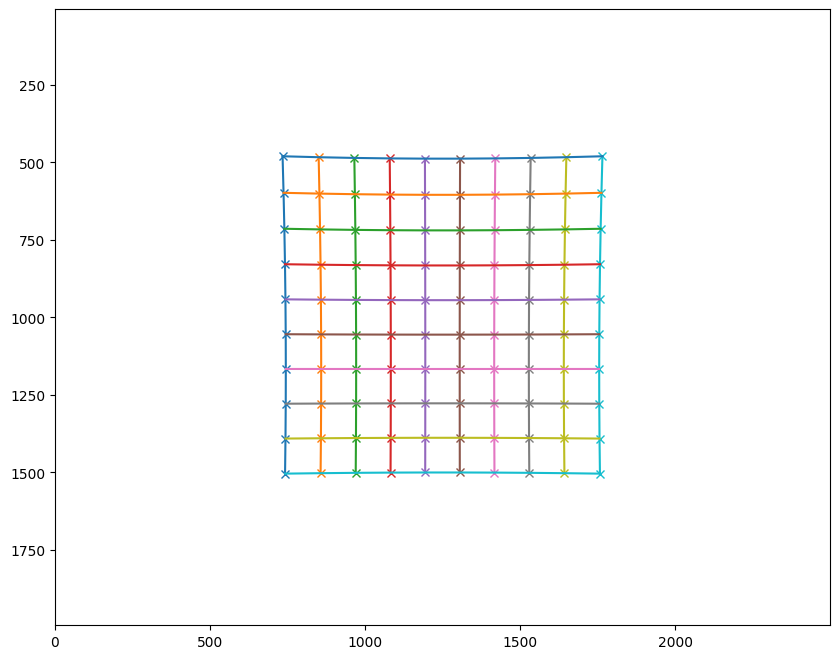

In [31]:
from oaf_vision_3d.project_points import project_points


points = np.stack(
    [
        *np.meshgrid(np.linspace(-20, 20, 10), np.linspace(-20, 20, 10)),
        100 * np.ones((10, 10)),
    ],
    axis=-1,
    dtype=np.float32,
)

pixels_0 = project_points(
    points=points.reshape(-1, 3),
    lens_model=lens_model_0,
).reshape(10, 10, 2)

plt.figure(figsize=(10, 8))
plt.plot(pixels_0[..., 0], pixels_0[..., 1], "x-")
plt.plot(pixels_0[..., 0].T, pixels_0[..., 1].T, "-")
plt.axis("equal")
plt.xlim(0, 2499)
plt.ylim(1999, 0)
plt.show()

We can then decide upon whatever transform we want between the first and second camera. We can use this to project the points into the second camera:

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


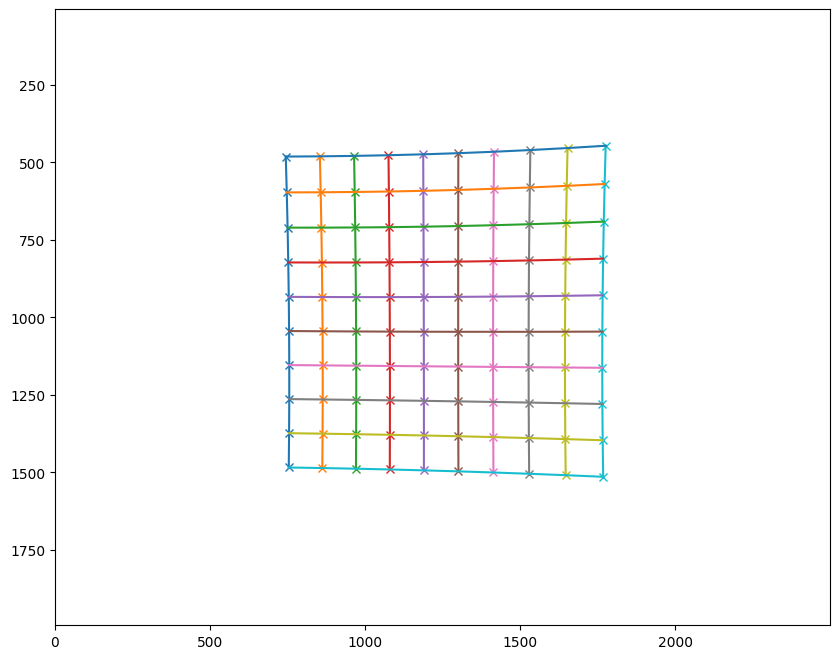

In [32]:
from oaf_vision_3d.transformation_matrix import TransformationMatrix


rvec = np.array([-0.002, -0.15, 0.001], dtype=np.float32)
tvec = np.array([15.0, 0.2, 2.1], dtype=np.float32)
transformation_matrix = TransformationMatrix.from_rvec_and_tvec(rvec=rvec, tvec=tvec)

pixels_1 = project_points(
    points=points.reshape(-1, 3),
    lens_model=lens_model_1,
    transformation_matrix=transformation_matrix.inverse(),
).reshape(10, 10, 2)

plt.figure(figsize=(10, 8))
plt.plot(pixels_1[..., 0], pixels_1[..., 1], "x-")
plt.plot(pixels_1[..., 0].T, pixels_1[..., 1].T, "-")
plt.axis("equal")
plt.xlim(0, 2499)
plt.ylim(1999, 0)
plt.show()

### Prepare data

Now that we have the data to triangulate we first need to prepare the data, what we need is:

- The undistorted normalized pixels for the main camera
- The undistorted normalized pixels for the second camera
- The transformation between the two cameras

We can calculate the undistorted normalized pixels of the cameras by using their respective lens models:

In [33]:
undistorted_normalized_pixels_0 = lens_model_0.undistort_pixels(
    lens_model_0.normalize_pixels(pixels=pixels_0)
)
undistorted_normalized_pixels_1 = lens_model_1.undistort_pixels(
    lens_model_1.normalize_pixels(pixels=pixels_1)
)

### Triangulate

We can than triangulate using the math discussed above:

In [ ]:
from nptyping import Float32, NDArray, Shape


def triangulate_points(
    undistorted_normalized_pixels_0: NDArray[Shape["H, W, 2"], Float32],
    undistorted_normalized_pixels_1: NDArray[Shape["H, W, 2"], Float32],
    transformation_matrix: TransformationMatrix,
) -> NDArray[Shape["H, W, 3"], Float32]:
    H, W, _ = undistorted_normalized_pixels_0.shape

    # Flatten to [N, 2] → Add z=1 to make rays [N, 3]
    v0 = undistorted_normalized_pixels_0.reshape(-1, 2)
    v0 = np.concatenate([v0, np.ones((v0.shape[0], 1), dtype=np.float32)], axis=1)

    v1 = undistorted_normalized_pixels_1.reshape(-1, 2)
    v1 = np.concatenate([v1, np.ones((v1.shape[0], 1), dtype=np.float32)], axis=1)

    # Extract rotation matrix and translation vector from the transformation
    R = transformation_matrix.rotation.as_matrix()  # [3, 3]
    t = transformation_matrix.translation            # [3,]

    # Rotate v1 into camera 0's frame
    v1_rotated = v1 @ R.T  # [N, 3]

    # Get P1 (camera 1 origin in camera 0 frame)
    P1 = t.reshape(1, 3)   # [1, 3] will broadcast correctly

    # Compute dot products
    a = np.sum(v0 * v0, axis=1)
    b = np.sum(v0 * v1_rotated, axis=1)
    c = np.sum(v1_rotated * v1_rotated, axis=1)
    d = np.sum(v0 * P1, axis=1)
    e = np.sum(v1_rotated * P1, axis=1)

    denom = b**2 - a * c
    denom = np.where(denom == 0, 1e-6, denom)

    t_val = (b * e - c * d) / denom

    # Get the triangulated point in camera 0's frame
    points_3d = (v0.T * t_val).T  # [N, 3]

    return points_3d.reshape(H, W, 3).astype(np.float32)

In [35]:
trianguated_points = triangulate_points(
    undistorted_normalized_pixels_0=undistorted_normalized_pixels_0,
    undistorted_normalized_pixels_1=undistorted_normalized_pixels_1,
    transformation_matrix=transformation_matrix,
)
trianguated_points = (
    np.zeros_like(points) if trianguated_points is None else trianguated_points
)

### Test

We can test the implementation by comparing the triangulated points with the original 3D points, feel free to go back and try different transformations between the cameras and/or different 3D points.

In [36]:
valid = np.allclose(points, trianguated_points, atol=1e-5)

print(f"Triangualtion {'succeeded' if valid else 'failed'}!")

Triangualtion succeeded!


### Visualization

We plot the 3D points and the triangulated points to see how well we did.

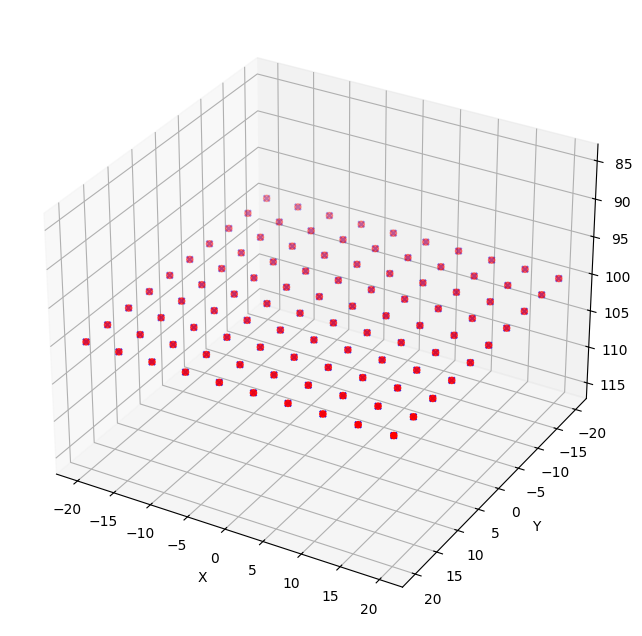

In [37]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[..., 0], points[..., 1], points[..., 2], c="r", marker="o")
ax.scatter(
    trianguated_points[..., 0],
    trianguated_points[..., 1],
    trianguated_points[..., 2],
    c="b",
    marker="x",
)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z") # type: ignore
ax.axis("equal")
ax.invert_yaxis()
ax.invert_zaxis() # type: ignore
plt.show()